In [153]:
# Installations
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# TODO: joins - concatenate all unchanged info throughout the years to one dataframe and leave all the others to the different dfs, merge those,
# see if the candidate changed their party throughout the years, merge it back based on names
# TODO: add years during df importing
# Feature engineering!
# wide df for clustering, long for classification (drop the duplicates?)

In [154]:
# Packages importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.catch_warnings(record=True)
warnings.simplefilter("ignore")
plt.rc("figure", figsize=(10,6))

In [155]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/rmnskb/cz-elections/main/dict_occupations.json"
response = urllib.request.urlopen(url)
encoding = response.info().get_content_charset("utf-8")
occup_dict = json.loads(response.read().decode(encoding))

def obor(row: str) -> str:
    global occup_dict
    for key in occup_dict.keys():
        for i in occup_dict[key]["var"]:
            if i in row:
                return occup_dict[key]["name"]
    return "Jiné"

occup_dict.keys()

dict_keys(['duchod', 'podnik', 'zivnost', 'remeslo', 'soukzam', 'finance', 'student', 'akademik', 'statzam', 'zdravotnictvi', 'politik', 'nezam', 'manager', 'zemedel', 'naboz', 'pravo', 'odbor', 'umeni', 'sport', 'nezaraz'])

In [156]:
def visualise_age_by_year(data: pd.DataFrame, years_list: list, title: str) -> None:
    """
    Visualise age distribution by gender across years. The function uses seaborn and matplotlib libraries for visualisation purposes.
    :param data: data across all the years in long format with required "year" column
    :param years_list: list of years that have to be visualised
    :param title: title of each plot, you may use {col_name} to show the year
    :return: return a facetted plot
    """
    import seaborn as sns
    import matplotlib as plt
    plt.rc("figure", figsize=(10,6))

    g = sns.displot(
        data=data, x="vek", hue="pohlavi", kind="kde", fill=True, legend=True, col="year"
    )
    g.set_titles(title)
    g.set(xlabel="Věk", ylabel="Hustota")
    # g.add_legend(labels=["Ženy", "Muži"], title="Pohlaví", loc="center right")

    years_avgs = {}
    for i, year in enumerate(years_list):
        years_avgs[i] = [data.query(f"year == {year}")["vek"].mean(),
                         data.query(f"year == {year}")["vek"].median(),
                         data.query(f"year == {year}")["vek"].mode().iat[0]]

    axes = g.axes.flatten()
    for i, ax in enumerate(axes):
        ax.axvline(years_avgs[i][0], ls="--", lw=1.0, label=f"""Průměr: {years_avgs[i][0]:.2f}""")
        ax.axvline(years_avgs[i][1], color="darkred", lw=1.0, label=f"""Medián: {years_avgs[i][1]:.2f}""")
        ax.axvline(years_avgs[i][2], ls="-.", color="orange", lw=1.0, label=f"""Modus: {years_avgs[i][2]:.2f}""")
        ax.legend(loc=0)

In [157]:
def clean_data(data: pd.DataFrame, strany: dict) -> pd.DataFrame:
    """
    Clean and prepare a dataframe containing data from different types of elections for further visualisation and modelling purposes.
        -[cele_jmeno]: Combining name columns into one
        -[vs_vzdelani]: Creating a boolean column checking whether a candidate has university degree
        -[POVOLANI]: canidate's profession
        -[pohlavi]: candidate's gender (based on their surname's ending)
        !-[pohlavi_encoded]: encoded genders
        -[kraj]: region where candidate runs their campaign
        !-[kraj_encoded]: encoded regions
        -[OSTRANA]: political party
        -[POCPROVSE]: percentage of votes at the election
    :param data: pandas dataframe including elections data
    :return: cleaned pandas dataframe
    """
    df = data.copy()

    df["cele_jmeno"] = df["JMENO"] + " " + df["PRIJMENI"]
    df["pohlavi"] = np.where(df.loc[:, "cele_jmeno"].str[-1] == "á", "F", "M")
    df["vs_vzdelani"] = np.where((df["TITULPRED"].notnull()) | (df["TITULZA"].notnull()), 1, 0)
    df["vek"] = df["VEK"]
    # Místo PSTRANA jsem vzal NSTRANA, jelikož u té první je hodně None
    # TODO: drop the rows with NA (only the year 2006 has 5% NA values, others are relatively good with it)
    kraj_list = ["Hlavní město Praha", "Středočeský kraj", "Jihočeský kraj", "Plzeňský kraj", "Karlovarský kraj",
                "Ústecký kraj", "Liberecký kraj", "Královéhradecký kraj", "Pardubický kraj", "Kraj Vysočina",
                "Jihomoravský kraj", "Olomoucký kraj", "Zlínský kraj", "Moravskoslezský kraj"]
    kraj_dict = dict(zip(list(range(1, 15)), kraj_list))
    df["ideologie"] = df["NSTRANA"].map(strany)
    df["kraj"] = df["VOLKRAJ"].map(kraj_dict)
    df["obor"] = df["POVOLANI"].apply(lambda row: obor(str(row)))
    df["mandat"] = df["MANDAT"]
    df["procento"] = df["POCPROC"]
    columns = ["cele_jmeno", "vek", "vs_vzdelani", "obor", "pohlavi", "kraj", "NSTRANA", "ideologie", "procento", "mandat", "year"]

    return df[columns]

In [158]:
snem_list = []
snem_years = [2006, 2010, 2013, 2017, 2021]
for year in snem_years:
    temp_df = pd.read_csv(f"https://raw.githubusercontent.com/rmnskb/cz-elections/main/legislative-elections/snem_{year}.csv",
                          sep=";", encoding="utf-8")
    temp_df["year"] = year
    snem_list.append(temp_df)

snem_list[0].head(20)

,VOLKRAJ,KSTRANA,PORCISLO,JMENO,PRIJMENI,TITULPRED,TITULZA,VEK,POVOLANI,BYDLISTEN,...,NSTRANA,PLATNOST,POCHLASU,POCPROC,POCPROCVSE,MANDAT,PORADIMAND,PORADINAHR,CPU,year
0,14,6,1,František,Zwyrtek,NaN,NaN,45,předseda hnutí,Český Těšín,...,88,0,120,0.0,2.86,0,0,0,NaN,2006
1,14,6,2,Vladimír,Mach,RNDr.,NaN,63,středoškolský profesor,Havířov,...,88,0,93,0.0,2.21,0,0,0,NaN,2006
2,14,6,3,Zdeněk,Stolař,PhDr.,NaN,51,psycholog,Frýdek-Místek,...,88,0,137,0.0,3.26,0,0,0,NaN,2006
3,14,6,4,Alena,Hasáková,PhDr.,NaN,51,středoškolský profesor,Český Těšín,...,88,0,124,0.0,2.95,0,0,0,NaN,2006
4,14,6,5,Alois,Čtvrtníček,Ing.,CSc.,60,podnikatel,Bruntál,...,88,0,35,0.0,0.83,0,0,0,NaN,2006
5,14,6,6,Hana,Doležalová,Mgr.,NaN,33,učitelka,Ostrava,...,88,0,81,0.0,1.93,0,0,0,NaN,2006
6,14,6,7,Václav,Kafka,Doc. Ing.,CSc.,63,výzkumný pracovník,Orlová,...,88,0,76,0.0,1.81,0,0,0,NaN,2006
7,14,6,8,Libuše,Koppová,NaN,NaN,59,zdravotní sestra,Třinec,...,88,0,95,0.0,2.26,0,0,0,NaN,2006
8,14,6,9,Alexander,Nedbálek,MUDr.,NaN,51,lékař,Havířov,...,88,0,48,0.0,1.14,0,0,0,NaN,2006
9,14,6,10,Jan,Fismol,Bc.,NaN,59,místostarosta,Dolní Lutyně,...,88,0,56,0.0,1.33,0,0,0,NaN,2006


In [159]:
strany = pd.read_csv("https://raw.githubusercontent.com/rmnskb/cz-elections/main/legislative-elections/strany.csv",
                    sep=";", encoding="utf-8")
strany_dict = dict(zip(strany["VSTRANA"], strany["Ideologie"]))
strany.head()

,VSTRANA,NAZEVCELK,ZKRATKAK8,Ideologie
0,1,Křesťanská a demokratická unie - Československ...,KDU-ČSL,Střed
1,2,Česká strana národně sociální,ČSNS,Levice
2,5,Strana zelených,SZ,Levice
3,7,Česká strana sociálně demokratická,ČSSD,Levice
4,11,Sdružení pro republiku-Republikánská strana Če...,SPR-RSČ,Pravice


In [160]:
snem_clean_list = []

for i in range(5):
    temp_df = clean_data(snem_list[i], strany_dict)
    snem_clean_list.append(temp_df)

snem_clean_list[0].head(20)

,cele_jmeno,vek,vs_vzdelani,obor,pohlavi,kraj,NSTRANA,ideologie,procento,mandat,year
0,František Zwyrtek,45,0,manažer,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
1,Vladimír Mach,63,1,Jiné,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
2,Zdeněk Stolař,51,1,zaměstnanec ve zdravotnictví,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
3,Alena Hasáková,51,1,Jiné,F,Moravskoslezský kraj,88,Střed,0.0,0,2006
4,Alois Čtvrtníček,60,1,podnikatel,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
5,Hana Doležalová,33,1,státní zaměstnanec,F,Moravskoslezský kraj,88,Střed,0.0,0,2006
6,Václav Kafka,63,1,Jiné,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
7,Libuše Koppová,59,0,zaměstnanec ve zdravotnictví,F,Moravskoslezský kraj,88,Střed,0.0,0,2006
8,Alexander Nedbálek,51,1,zaměstnanec ve zdravotnictví,M,Moravskoslezský kraj,88,Střed,0.0,0,2006
9,Jan Fismol,59,1,politik,M,Moravskoslezský kraj,88,Střed,0.0,0,2006


In [161]:
for index, year in enumerate(snem_years):
    snem_clean_list[index]["year"] = year

snem_long = pd.concat(snem_clean_list, ignore_index=True)
snem_long.tail(10)

,cele_jmeno,vek,vs_vzdelani,obor,pohlavi,kraj,NSTRANA,ideologie,procento,mandat,year
28768,Michal Havlík,42.0,0,podnikatel,M,Moravskoslezský kraj,83.0,Pravice,"0,42",N,2021
28769,Michaela Hanzlík Skarabellová,51.0,0,manažer,F,Moravskoslezský kraj,83.0,Pravice,"0,77",N,2021
28770,Jiří Minařík,51.0,0,manažer,M,Moravskoslezský kraj,83.0,Pravice,"1,16",N,2021
28771,Vladimír Herout,62.0,0,Jiné,M,Moravskoslezský kraj,83.0,Pravice,"0,74",N,2021
28772,František Kolínek,43.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,38",N,2021
28773,Roman Zvoníček,46.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,31",N,2021
28774,Tomáš Kleibl,25.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,88",N,2021
28775,Alois Nezbeda,77.0,0,Jiné,M,Moravskoslezský kraj,83.0,Pravice,"0,81",N,2021
28776,Jiří Žváček,58.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,49",N,2021
28777,Petr Srovnal,61.0,0,zaměstnanec v soukromém sektoru,M,Moravskoslezský kraj,83.0,Pravice,"0,7",N,2021


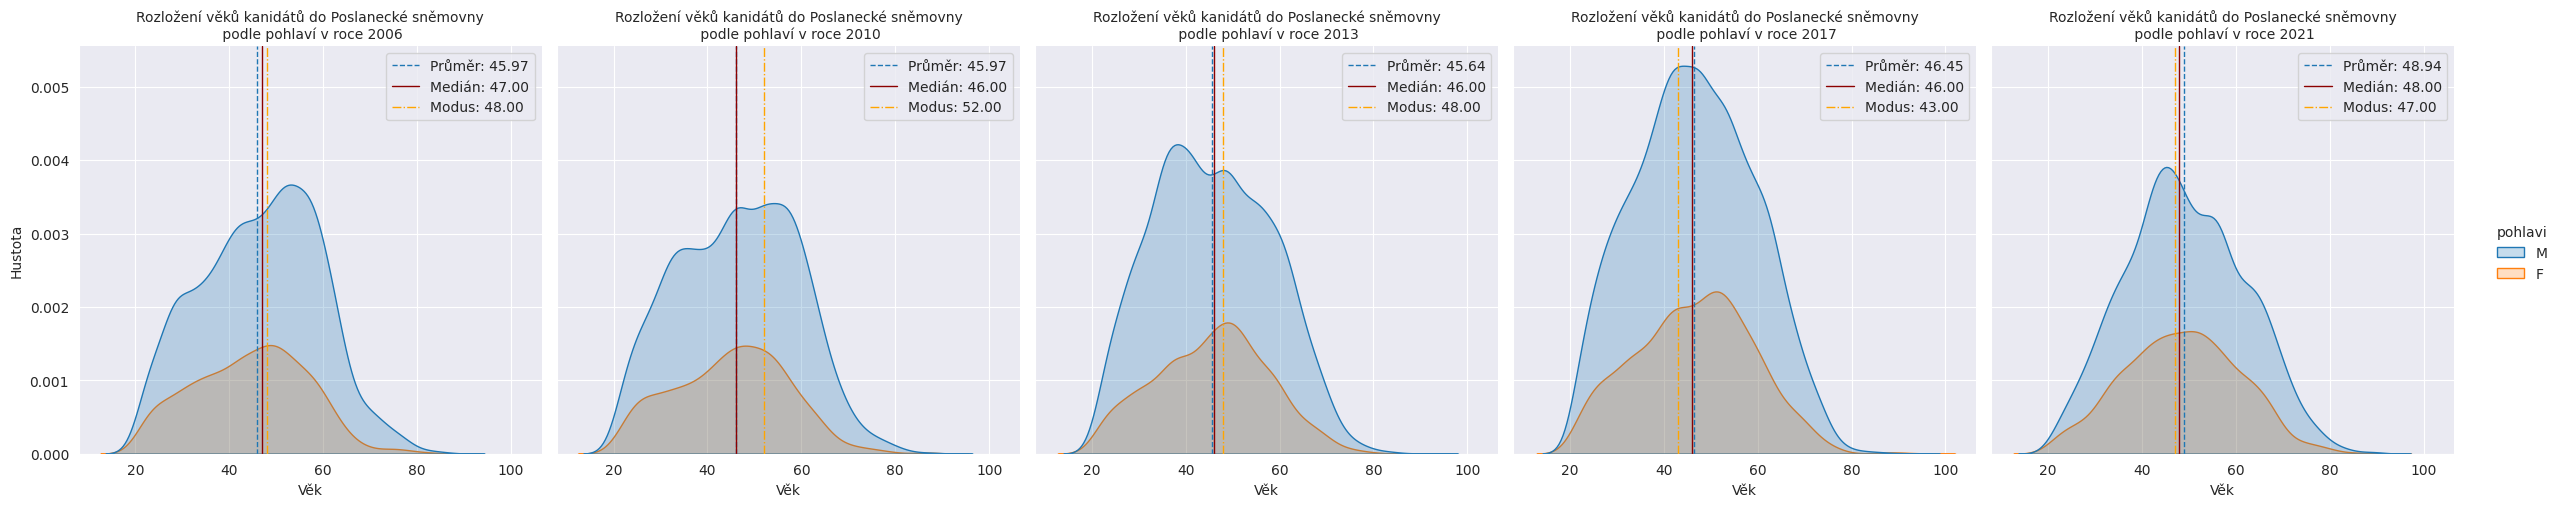

In [162]:
visualise_age_by_year(data=snem_long, years_list=snem_years,
                      title="Rozložení věků kanidátů do Poslanecké sněmovny\n podle pohlaví v roce {col_name}")

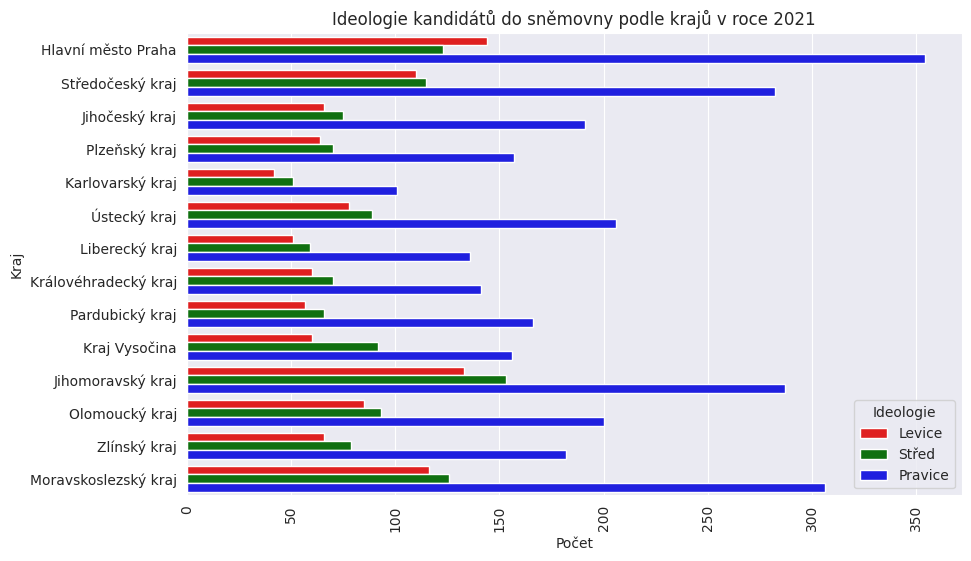

In [164]:
hue_order = ["Levice", "Střed", "Pravice"]
sns.countplot(snem_clean_list[4], y="kraj", hue="ideologie",
              hue_order=hue_order, palette=["Red", "Green", "Blue"])
plt.xticks(rotation=90)
plt.title("Ideologie kandidátů do sněmovny podle krajů v roce 2021")
plt.xlabel("Počet")
plt.ylabel("Kraj")
plt.legend(title="Ideologie");

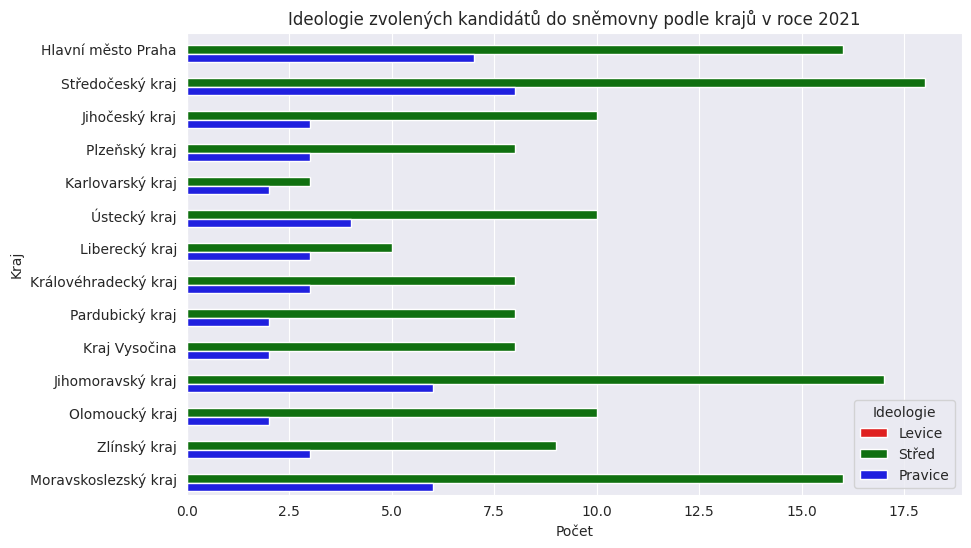

In [165]:
hue_order = ["Levice", "Střed", "Pravice"]
sns.countplot(snem_clean_list[4][snem_clean_list[4]["mandat"] == "A"], y="kraj", hue="ideologie",
              hue_order=hue_order, palette=["Red", "Green", "Blue"])
# plt.xticks(rotation=90)
plt.title("Ideologie zvolených kandidátů do sněmovny podle krajů v roce 2021")
plt.xlabel("Počet")
plt.ylabel("Kraj")
plt.legend(title="Ideologie");

In [166]:
# TODO: wide df with for loop
snem_2017 = snem_clean_list[3]
snem_2021 = snem_clean_list[4]

snem_17_21 = snem_2017.merge(snem_2021, how="outer", on=["cele_jmeno", "vs_vzdelani", "pohlavi", "kraj"],
                             suffixes=["_2017", "_2021"])

snem_17_21.head()

,cele_jmeno,vek_2017,vs_vzdelani,obor_2017,pohlavi,kraj,NSTRANA_2017,ideologie_2017,procento_2017,mandat_2017,year_2017,vek_2021,obor_2021,NSTRANA_2021,ideologie_2021,procento_2021,mandat_2021,year_2021
0,Jana Černochová,43.0,1,Jiné,F,Hlavní město Praha,53.0,Pravice,"12,52",A,2017.0,47.0,Jiné,53.0,Pravice,"14,17",A,2021.0
1,Filip Humplík,45.0,0,podnikatel,M,Hlavní město Praha,53.0,Pravice,"5,05",N,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Václav Klaus,48.0,1,státní zaměstnanec,M,Hlavní město Praha,53.0,Pravice,"22,82",A,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bohuslav Svoboda,73.0,1,akademik,M,Hlavní město Praha,53.0,Pravice,"12,46",A,2017.0,77.0,zaměstnanec ve zdravotnictví,53.0,Pravice,"11,56",A,2021.0
4,Jaroslava Janderová,67.0,1,podnikatel,F,Hlavní město Praha,53.0,Pravice,0,N,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
# TODO: check if the candidate changed the party throughout the years
snem_17_21["changed_party"] = np.where((snem_17_21["NSTRANA_2017"] != snem_17_21["NSTRANA_2021"]) & (snem_17_21["NSTRANA_2017"].notnull() & snem_17_21["NSTRANA_2021"].notnull()), 1, 0)

snem_17_21[snem_17_21["changed_party"] == 1][["NSTRANA_2017", "NSTRANA_2021", "changed_party"]].head(20)

,NSTRANA_2017,NSTRANA_2021,changed_party
10,53.0,1227.0,1
18,53.0,1227.0,1
25,53.0,1227.0,1
79,1177.0,1007.0,1
95,7.0,1114.0,1
217,47.0,74.0,1
229,5.0,7.0,1
257,5.0,74.0,1
270,137.0,1173.0,1
271,137.0,1173.0,1
